# NLP - CA2
## Spam Classifier
### Parnian Fazel - 810198516

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import preprocessing
import seaborn as sns
import nltk

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Parnian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Parnian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Parnian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Parnian\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("spam.csv", encoding = "latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

#### Dropping 3 unusefuls columns : Unnamed: 2, Unnamed: 3, Unnamed: 4 & Renaming columns

In [5]:
df = df.rename(columns={"v1": "category", "v2": "sms"})
columns_list_to_keep = ["category", "sms"]
df = df[columns_list_to_keep]
df.head(10)

,category,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
print(df.shape)

(5572, 2)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5572 non-null   object
 1   sms       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.isna().sum()

category    0
sms         0
dtype: int64

ham     4825
spam     747
Name: category, dtype: int64
------------------------------------


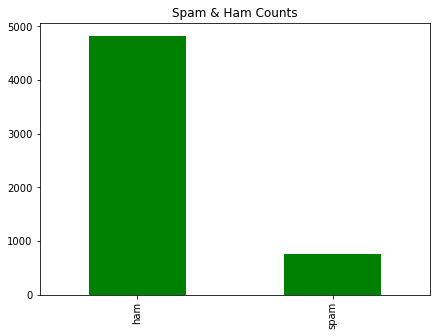

In [9]:
print(df["category"].value_counts())
print("------------------------------------")

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.title('Spam & Ham Counts')
df["category"].value_counts().plot.bar(color = 'green')
plt.show()

### Labeling spam and ham by 1 and 0

In [10]:
df["category"] = np.where(df["category"] == "ham", 0, 1)

### Feature Extraction

In [11]:
def calculate_bag_of_words(x_train, x_test):
    x_train_texts = [' '.join(item) for item in x_train]
    x_test_texts = [' '.join(item) for item in x_test]
    vectorizer = CountVectorizer()
    training_data = vectorizer.fit_transform(x_train_texts)
    test_data  = vectorizer.transform(x_test_texts)
    return training_data.toarray(), test_data.toarray()

def check_if_it_has_urls(text):
    import re
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    if(len(urls) > 0):
        return 1
    else:
        return 0
    
def get_number_of_spam_key_words(text):
    token_words = []
    with open('spam_words.txt', 'r') as fp:
        c = fp.read()
        token_words = c.split('\n')
    words = clean_text(text)
    text = [' '.join(item) for item in words]
    num = 0
    for w in words:
        if w in token_words:
            num += 1
    return num

def check_if_it_has_phonenumber(text):
    import re
    phonenumbers = re.findall('\+?\d\d\d\d\d\d\d\d\d\d\d\d', text)
    if (len(phonenumbers) > 0):
        return 1
    else:
        return 0
    
def check_if_it_has_currency_sign(text):
    import re
    currency = re.findall('£|\$|\€|\¥', text)
    if (len(currency) > 0):
        return 1
    else:
        return 0

def get_number_of_uppercase_letters(text):
    all_words = nltk.word_tokenize(text)
    num_of_uppercase = 0 
    for w in all_words:
        if w.isupper():
            num_of_uppercase += 1
    return num_of_uppercase


def extract_features(actual_X_train, preprocessed_data_train, actual_X_test, preprocessed_data_test):
    
    bow_output_train, bow_output_test = calculate_bag_of_words(preprocessed_data_train, preprocessed_data_test)
    print("shape: ", bow_output_train.shape)
    new_train_df = pd.DataFrame(bow_output_train)
    new_test_df = pd.DataFrame(bow_output_test)
    #extracting lenght
    new_train_df = pd.concat([new_train_df, actual_X_train.apply(lambda x: len(x)).rename('length')], axis=1)
    new_test_df = pd.concat([new_test_df,actual_X_test.apply(lambda x: len(x)).rename('length')], axis=1)
    #extracting uppercase words
    new_train_df = pd.concat([new_train_df, actual_X_train.apply(lambda x: get_number_of_uppercase_letters(x)).rename('#upper_case')], axis=1)
    new_test_df = pd.concat([new_test_df,actual_X_test.apply(lambda x: get_number_of_uppercase_letters(x)).rename('#upper_case')], axis=1)
    #extracting url
    new_train_df = pd.concat([new_train_df, actual_X_train.apply(lambda x: check_if_it_has_urls(x)).rename('url')], axis=1)
    new_test_df = pd.concat([new_test_df,actual_X_test.apply(lambda x: check_if_it_has_urls(x)).rename('url')], axis=1)
    #extracting phone number
    new_train_df = pd.concat([new_train_df, actual_X_train.apply(lambda x: check_if_it_has_phonenumber(x)).rename('phone_number')], axis=1)
    new_test_df = pd.concat([new_test_df,actual_X_test.apply(lambda x: check_if_it_has_phonenumber(x)).rename('phone_number')], axis=1)
    #extracting currency sign
    new_train_df = pd.concat([new_train_df, actual_X_train.apply(lambda x: check_if_it_has_currency_sign(x)).rename('currency_sign')], axis=1)
    new_test_df = pd.concat([new_test_df,actual_X_test.apply(lambda x: check_if_it_has_currency_sign(x)).rename('currency_sign')], axis=1)
    #extracting keywords
    new_train_df = pd.concat([new_train_df, actual_X_train.apply(lambda x: get_number_of_spam_key_words(x)).rename('#key_words')], axis=1)
    new_test_df = pd.concat([new_test_df,actual_X_test.apply(lambda x: get_number_of_spam_key_words(x)).rename('#key_words')], axis=1)

    return new_train_df, new_test_df

### Cleaning Data

In [12]:
def get_word_tokens(raw):
    return nltk.word_tokenize(raw)

def remove_stop_words(tokens):
    return [word for word in tokens if not word in nltk_stopwords.words("english")]

def normalize_words(tokens):
    tokens = [word.lower() for word in tokens]
    return tokens

def lemmatize_words(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def clean_text(text):
    tokens = get_word_tokens(text)
    tokens = normalize_words(tokens)
    tokens = remove_stop_words(tokens)
    tokens = lemmatize_words(tokens)
    return tokens

def clean_data(all_X):
    cleaned_X = []
    for item in all_X:
        cleaned_item = clean_text(item)
        cleaned_X.append(cleaned_item)
    return cleaned_X

### Trainig the naive bayes model

In [13]:
def train_the_model(x_train, x_test, y_train):
    x_train, x_test, y_train = np.array(x_train), np.array(x_test), np.array(y_train)
    NB = MultinomialNB()
    y_pred = NB.fit(x_train, y_train).predict(x_test)
    return y_pred

In [14]:
df.head(10)

,category,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [15]:
def print_confusion_matrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot = True, ax = ax, linewidths = 5, linecolor = 'y', center = 0)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels') 
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Ham','Spam'])
    ax.yaxis.set_ticklabels(['Ham','Spam'])
    plt.show()

def evaluate(y_test, y_pred):
    print(f"Accuracy: {format(accuracy_score(y_test, y_pred))}")
    print(f"Recall: {format(recall_score(y_test, y_pred))}")
    print(f"Precision: {format(precision_score(y_test, y_pred))}")
    print(f"F1 score: {format(f1_score(y_test, y_pred))}")
    print("classification report:\n", classification_report(y_test, y_pred))

shape:  (4457, 7290)
-----------------------------------------
number of train items:  4457
number of test items:  1115
-----------------------------------------
train value counts:
 0    3855
1     602
Name: category, dtype: int64
----------------
test value counts
 0    970
1    145
Name: category, dtype: int64
-----------------------------------------
Accuracy: 0.9847533632286996
Recall: 0.9172413793103448
Precision: 0.9637681159420289
F1 score: 0.939929328621908
classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       970
           1       0.96      0.92      0.94       145

    accuracy                           0.98      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



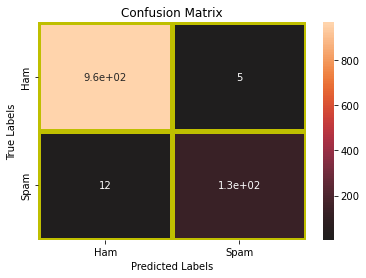

In [16]:
def classify(df):
    x_train, x_test, y_train, y_test = train_test_split(df["sms"], df["category"], test_size = 0.2, random_state = 100)
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)

    preprocessed_data_train = clean_data(x_train)
    preprocessed_data_test = clean_data(x_test)
    all_features_X_train, all_features_X_test = extract_features(x_train, preprocessed_data_train, x_test, preprocessed_data_test)

    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_train = min_max_scaler.fit_transform(all_features_X_train.values)
    scaled_test = min_max_scaler.fit_transform(all_features_X_test.values)

    y_pred = train_the_model(scaled_train, scaled_test, y_train)

    print('-----------------------------------------')
    print('number of train items: ', len(x_train))
    print('number of test items: ', len(x_test))
    print('-----------------------------------------')
    print('train value counts:\n', y_train.value_counts())
    print('----------------')
    print('test value counts\n', y_test.value_counts())
    print('-----------------------------------------')
    y_pred = train_the_model(all_features_X_train, all_features_X_test, y_train)
    evaluate(y_test, y_pred)
    print_confusion_matrix(y_test, y_pred)
    
classify(df)